In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
from h5py import File
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader, Subset
from vis_utils import plot_time_series
import numpy as np

In [2]:
# define the transform function
trans = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, path: str,
                 response_type: str,
                 sequence_length: int = 10,
                 transform: transforms.Compose = trans,
                 train: bool= True):
        self.file_path = path
        # The available types are firing_rate_10ms, binned
        self.response_type = response_type
        self.X = None
        self.y = None
        self.transform = transform
        # Choose either train or test subsets
        self.data_type = "train" if train else "test"

        self.sequence_length = sequence_length
        with File(self.file_path, 'r') as file:
            self.dataset_len = len(file[self.data_type]["stimulus"][:500])

    def __getitem__(self, idx: int):
        if self.X is None or self.y is None:
            h5file = File(self.file_path, 'r')
            # Read as numpy array
            # TODO: see if there is a better way
            self.X = np.asarray(h5file[self.data_type]["stimulus"][:500])
            self.y = np.asarray(h5file[self.data_type]["response"][self.response_type][:500])
            # Swap axes of y since it is channels last
            self.y = np.transpose(self.y, axes=None)
            self.y = self.y.astype("float32")

        # Handle wrapping around the dataset for indices less than sequence length
        if idx < self.sequence_length - 1:
            wrapped_indices = [(idx - i) % self.dataset_len for i in range(self.sequence_length)]
            wrapped_indices = wrapped_indices[::-1]  # Reverse to maintain the correct order
        else:
            wrapped_indices = list(range(idx - self.sequence_length + 1, idx + 1))

        # Get the sequence of images
        x_sequence = self.X[wrapped_indices]
        
        # Transform each image in the sequence if a transform is provided
        if self.transform:
            x_sequence = np.array([self.transform(img) for img in x_sequence])
        x_sequence = torch.tensor(x_sequence, dtype=torch.float32)
        
        # Get the response of the last image in the sequence
        y = torch.tensor(self.y[idx][0], dtype=torch.float32)
        
        return x_sequence, y

    def __len__(self):
        return self.dataset_len

In [4]:
# adjust a path to the sample h5 file
dataset_path = "../data/neural_code_data/neural_code_data/ganglion_cell_data/15-10-07/naturalscene.h5"

train_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=True)
val_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=True)
test_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=False)

In [5]:
# # Determine the split point
# dataset_len = len(train_dataset)
# train_split = int(0.8 * dataset_len)  # 80% for training
# val_split = dataset_len - train_split  # 20% for validation

# train_indices = list(range(train_split))
# val_indices = list(range(train_split, dataset_len))

# train_dataset = Subset(train_dataset, train_indices)
# val_dataset = Subset(train_dataset, val_indices)

print("Number of training images", len(train_dataset))
print("Number of validation images", len(val_dataset))
print("Number of testing images", len(test_dataset))

Number of training images 500
Number of validation images 500
Number of testing images 500


In [6]:
# create data loaders
BATCH_SIZE = 500
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class RetinaCNN(nn.Module):
    def __init__(self, 
                 out_channels: int = 8,
                 n_units: int = 9):
        super(RetinaCNN, self).__init__()
        self.out_channels = out_channels
        self.n_units = n_units
        self.bn_moment = 0.1

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-3, momentum=self.bn_moment)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=2 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(2 * out_channels, eps=1e-3, momentum=self.bn_moment)
        self.conv3 = nn.Conv2d(in_channels=2 * out_channels, out_channels=4 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(4 * out_channels, eps=1e-3, momentum=self.bn_moment)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)
        
        x = nn.Flatten()(x)
        return x

class CNNRNNModel(nn.Module):
    def __init__(self, image_shape, sequence_length, out_channels: int = 8, n_units: int = 9):
        super(CNNRNNModel, self).__init__()
        self.sequence_length = sequence_length

        # Define the CNN part using RetinaCNN
        self.cnn = RetinaCNN(out_channels, n_units)

        # Calculate the size of the feature map after the CNN layers
        with torch.no_grad():
            self.feature_size = self.cnn(torch.zeros(1, *image_shape)).shape[1]

        # Define the RNN part
        self.rnn = nn.LSTM(input_size=self.feature_size, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128, n_units)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.shape
        cnn_out = []
        for t in range(seq_len):
            cnn_out.append(self.cnn(x[:, t]))
        cnn_out = torch.stack(cnn_out, dim=1)
        rnn_out, _ = self.rnn(cnn_out)
        output = self.fc(rnn_out[:, -1])
        output = nn.Softplus()(output)
        return output

In [8]:
x, y = next(iter(train_loader))
model = CNNRNNModel((1, 50, 50), sequence_length=10, n_units=1)
model.cuda()
model.train()


CNNRNNModel(
  (cnn): RetinaCNN(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (rnn): LSTM(80000, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=1.0):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets):
        weights = torch.where(targets > 1, self.weight, 1.0)
        return torch.mean(weights * (inputs - targets) ** 2)

In [10]:
# define training parameters
LEARNING_RATE = 0.005
EPOCHS = 50
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = WeightedMSELoss(weight=10)

In [11]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()
model.train()

for epoch in range(EPOCHS):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader, desc='Training Batches', leave=False):
        model.zero_grad()
        optimizer.zero_grad()
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    model.eval()
    fin_targets=[]
    fin_outputs=[]
    valid_batch_losses=[]
    with torch.no_grad():
        for data, labels in val_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > train_loss:
        torch.save(model.state_dict(), '../models/best_CNNRNN.pth')
        min_valid_loss = train_loss
    
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    # print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss}')


    torch.save(model.state_dict(), '../models/final_CNNRNN.pth')

Training Batches:   0%|          | 0/1 [00:00<?, ?it/s]/root/miniconda3/envs/neural_deep/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 		 Training Loss: 4334.458984375 		 Validation Loss: 4143.4521484375


Epoch 2 		 Training Loss: 4148.7041015625 		 Validation Loss: 4115.1630859375


Epoch 3 		 Training Loss: 4118.95263671875 		 Validation Loss: 4090.69921875


Epoch 4 		 Training Loss: 4093.21728515625 		 Validation Loss: 4067.092529296875


Epoch 5 		 Training Loss: 4067.744140625 		 Validation Loss: 4044.06201171875


Epoch 6 		 Training Loss: 4044.128662109375 		 Validation Loss: 4020.64208984375


Epoch 7 		 Training Loss: 4020.9443359375 		 Validation Loss: 3998.183349609375


Epoch 8 		 Training Loss: 3998.287353515625 		 Validation Loss: 3974.53271484375


Epoch 9 		 Training Loss: 3975.6806640625 		 Validation Loss: 3951.861328125


Epoch 10 		 Training Loss: 3953.34814453125 		 Validation Loss: 3929.30322265625


Epoch 11 		 Training Loss: 3931.243408203125 		 Validation Loss: 3907.414794921875


Epoch 12 		 Training Loss: 3909.093017578125 		 Validation Loss: 3885.6728515625


Epoch 13 		 Training Loss: 3886.35400390625 		 Validation Loss: 3864.07421875


Epoch 14 		 Training Loss: 3865.114013671875 		 Validation Loss: 3843.1416015625


Epoch 15 		 Training Loss: 3843.6591796875 		 Validation Loss: 3823.814208984375


Epoch 16 		 Training Loss: 3822.577392578125 		 Validation Loss: 3805.184814453125


Epoch 17 		 Training Loss: 3802.39208984375 		 Validation Loss: 3784.658203125


Epoch 18 		 Training Loss: 3781.5537109375 		 Validation Loss: 3761.94384765625


Epoch 19 		 Training Loss: 3762.00341796875 		 Validation Loss: 3742.9755859375


Epoch 20 		 Training Loss: 3742.9755859375 		 Validation Loss: 3724.357666015625


Epoch 21 		 Training Loss: 3724.357666015625 		 Validation Loss: 3706.1552734375


Epoch 22 		 Training Loss: 3706.1552734375 		 Validation Loss: 3688.37060546875


Epoch 23 		 Training Loss: 3688.37060546875 		 Validation Loss: 3671.005615234375


Epoch 24 		 Training Loss: 3671.005615234375 		 Validation Loss: 3654.060546875


Epoch 25 		 Training Loss: 3654.060546875 		 Validation Loss: 3637.535888671875


Epoch 26 		 Training Loss: 3637.535888671875 		 Validation Loss: 3621.431396484375


Epoch 27 		 Training Loss: 3621.431396484375 		 Validation Loss: 3605.744384765625


Epoch 28 		 Training Loss: 3605.744384765625 		 Validation Loss: 3590.47412109375


Epoch 29 		 Training Loss: 3590.47412109375 		 Validation Loss: 3575.6171875


Epoch 30 		 Training Loss: 3575.6171875 		 Validation Loss: 3561.171142578125


Epoch 31 		 Training Loss: 3561.171142578125 		 Validation Loss: 3547.1318359375


Epoch 32 		 Training Loss: 3547.1318359375 		 Validation Loss: 3533.495361328125


Epoch 33 		 Training Loss: 3533.495361328125 		 Validation Loss: 3520.257568359375


Epoch 34 		 Training Loss: 3520.257568359375 		 Validation Loss: 3507.413818359375


Epoch 35 		 Training Loss: 3507.413818359375 		 Validation Loss: 3494.95849609375


Epoch 36 		 Training Loss: 3494.95849609375 		 Validation Loss: 3482.88720703125


Epoch 37 		 Training Loss: 3482.88720703125 		 Validation Loss: 3471.193115234375


Epoch 38 		 Training Loss: 3471.193115234375 		 Validation Loss: 3459.871337890625


Epoch 39 		 Training Loss: 3459.871337890625 		 Validation Loss: 3448.91552734375


Epoch 40 		 Training Loss: 3448.91552734375 		 Validation Loss: 3438.319091796875


Epoch 41 		 Training Loss: 3438.319091796875 		 Validation Loss: 3428.07568359375


Epoch 42 		 Training Loss: 3428.07568359375 		 Validation Loss: 3418.178955078125


Epoch 43 		 Training Loss: 3418.178955078125 		 Validation Loss: 3408.62255859375


Epoch 44 		 Training Loss: 3408.62255859375 		 Validation Loss: 3399.39892578125


Epoch 45 		 Training Loss: 3399.39892578125 		 Validation Loss: 3390.50146484375


Epoch 46 		 Training Loss: 3390.50146484375 		 Validation Loss: 3381.922607421875


Epoch 47 		 Training Loss: 3381.922607421875 		 Validation Loss: 3373.656005859375


Epoch 48 		 Training Loss: 3373.656005859375 		 Validation Loss: 3365.694091796875


Epoch 49 		 Training Loss: 3365.694091796875 		 Validation Loss: 3358.029296875


Epoch 50 		 Training Loss: 3358.029296875 		 Validation Loss: 3350.655517578125


In [34]:
# function for a test loader predictions
def predict_loader(model, data_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc='Batches'):
            images = data.cuda()
            targets = labels.cuda()
            # targets = torch.expm1(targets)
            outputs = model(images)
            # outputs = torch.expm1(outputs)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    return np.array(fin_outputs), np.array(fin_targets)

In [35]:
# load the best model
model = CNNRNNModel((1,50,50), sequence_length=10, n_units=1)
model.load_state_dict(torch.load('../models/best_CNNRNN.pth'))
model.cuda()

CNNRNNModel(
  (cnn): RetinaCNN(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (rnn): LSTM(80000, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [53]:
predictions, targets = predict_loader(model, train_loader)

Batches: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


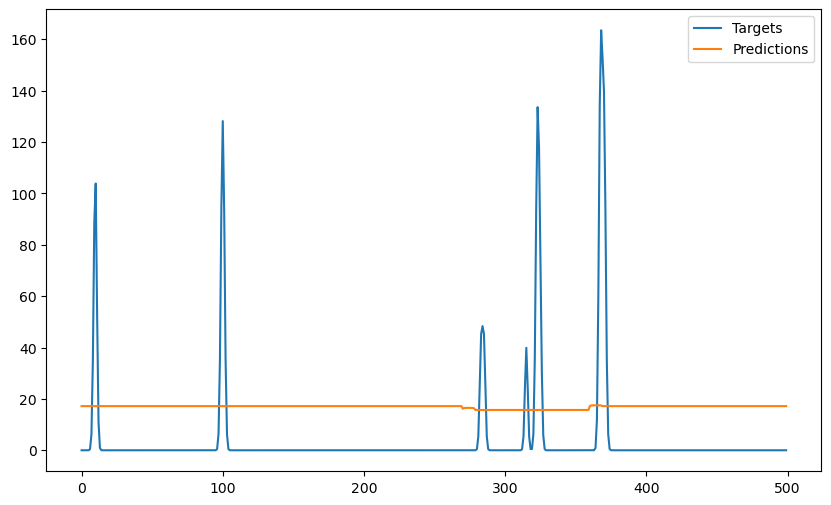

In [54]:
predictions = predictions.flatten()

# plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(targets, label='Targets')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()